# Sequence Level Features and Analysis

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ttest_1samp

pd.set_option('display.float_format', '{:.10e}'.format)
pd.set_option('display.max_colwidth', 30)

In [5]:
csv_file = "../Data/R12-clean.csv"
df = pd.read_csv(csv_file)
df.head(5)

,Sequence,Copy Num,Length
0,AGTGCCATCGTGCGTATCCTTCACTC...,91,98
1,AGTGCCATCGTGCGTATCCTTCACGT...,86,98
2,AGTGCCATCGTGCGTATCCTGAACAT...,83,98
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80,98
4,AGTGCCATCGTGCGTATCCTGAACAT...,78,98


### 1. Base Composition

In [25]:
# Ratio of GC to AT content
def GC_content(sequence):
    count = Counter(sequence)
    return (count['G'] + count['C'])/len(sequence)

In [27]:
df['GC content'] = df['Sequence'].apply(GC_content)

In [53]:
mean_GC = np.mean(df['GC content'])
median_GC = np.median(df['GC content'])
print(f'Mean: {np.round(mean_GC, 5)}\nMedian: {np.round(median_GC, 5)}')

Mean: 0.53351
Median: 0.53061


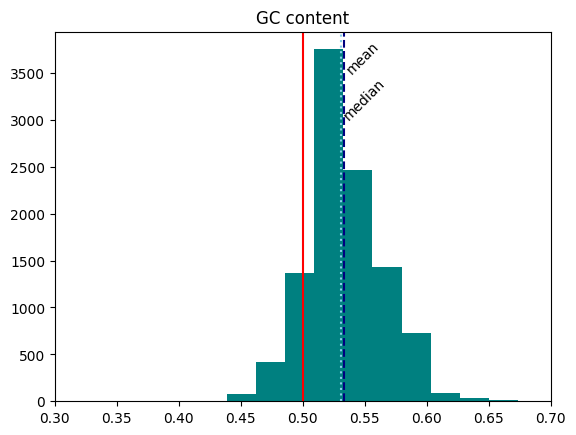

In [54]:
plt.hist(df['GC content'], color= 'teal')
plt.title('GC content')
plt.xlim(0.3, 0.7)
plt.axvline(x=0.5, color='red')
# show mean and median lines
plt.axvline(x=mean_GC, color='navy', linestyle='--', label='Mean')
plt.axvline(x=median_GC, color='skyblue', linestyle='dotted', label='Median')
plt.text(mean_GC, 3500, 'mean', rotation=45)
plt.text(median_GC, 3000, 'median', rotation=45)
plt.show()

In [59]:
np.sum(df['GC content'] > 0.5)/len(df['GC content'])

0.8247134739477993

Interestingly, the GC content seems to skew left.  An unbiased set of sequences might expect the GC% to be around 0.5, but we can see a majority of sequences have higher than expected GC content. In fact, about 82.5% of the sequences have higher than 50% GC content. Specific motifs or structural elements that are GC-rich may have been selected.  GC rich sequences often form more stable secondary structures.

#### a. One sample t-test

In [70]:
t_stat, p_val = ttest_1samp(df['GC content'], 0.5)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: 110.4588265736308, P-value: 0.0


The GC content being higher is statistically significant.  We cannot be sure of biological importance, however.

### 2. k-mer Frequency  
Importantly, we have to normalize for the presence of FP, RP, and Mipomersen loading constant regions.

In [75]:
def extract_kmers(seq, k):
    """Extracts kmers from a sequence and saves them as a sublist
    which preserves order and distance from each other. Returns a list
    of sublists which represent the k-1 possible reading frames."""
    all_kmers = [
        [seq[i:i+k] for i in range(frame, len(seq), k)]
        for frame in range(k)
    ]
    return all_kmers

In [77]:
def kmer_frequency(kmers):
    """Calculate kmer frequencies."""
    kmer_counts = Counter(kmers)
    total_kmers = sum(kmer_counts.values())
    return {kmer: count/total_kmers for kmer, count in kmer_counts.items()}

#### a. 3-mers

In [88]:
# Make a new dataframe with k-1 columns for each frame
k=3
kmer_df = pd.DataFrame(df['Sequence'])
  
extracted = kmer_df['Sequence'].apply(lambda seq: extract_kmers(seq, k))

kmer_frequency(extracted[0][0])

{'AGT': 0.06060606060606061,
 'GCC': 0.030303030303030304,
 'ATC': 0.06060606060606061,
 'GTG': 0.030303030303030304,
 'CGT': 0.06060606060606061,
 'CTT': 0.030303030303030304,
 'CAC': 0.030303030303030304,
 'TCC': 0.030303030303030304,
 'TTG': 0.030303030303030304,
 'CTC': 0.030303030303030304,
 'GAC': 0.030303030303030304,
 'AAG': 0.06060606060606061,
 'CGA': 0.06060606060606061,
 'AGC': 0.030303030303030304,
 'AGA': 0.06060606060606061,
 'CTG': 0.06060606060606061,
 'AGG': 0.030303030303030304,
 'CCG': 0.030303030303030304,
 'ATG': 0.030303030303030304,
 'GTC': 0.030303030303030304,
 'TAA': 0.030303030303030304,
 'TTC': 0.06060606060606061,
 'GAG': 0.030303030303030304,
 'ACA': 0.030303030303030304,
 'CG': 0.030303030303030304}

In [ ]:
# Get kmer frequencies
kmer_df[f'Frequency'] = df['Frame_0'].apply(lambda kmers: kmer_frequency(kmers